The `merkle` package contains Python code that will be used throughout this notebook.

First, let us run the unittests in that package to ensure they pass.

In [1]:
import unittest

loader = unittest.TestLoader()
suite = loader.discover(start_dir="merkle", top_level_dir=".")
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

# Alternatively, run the following from the command line in the directory containing the merkle package:
# python -m unittest discover -s merkle -t . -v


test_with_tree_over_eleven_leaf_nodes (merkle.tests.test_node.TestMutualParentOfSiblings) ... ok
test_with_tree_over_five_leaf_nodes (merkle.tests.test_node.TestMutualParentOfSiblings) ... ok
test_with_tree_over_four_leaf_nodes (merkle.tests.test_node.TestMutualParentOfSiblings) ... ok
test_with_tree_over_eleven_leaf_nodes (merkle.tests.test_node.TestNodeReference) ... ok
test_with_tree_over_five_leaf_nodes (merkle.tests.test_node.TestNodeReference) ... ok
test_with_tree_over_six_leaf_nodes (merkle.tests.test_node.TestNodeReference) ... ok
test_traversal_in_tree_over_eleven_leaf_nodes (merkle.tests.test_tree.TestTraversal) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.003s

OK


<unittest.runner.TextTestResult run=7 errors=0 failures=0>

We can use the `anytree` Python module to construct the nodes of a Merkle tree. Make sure that you have installed `anytree` in your Python environment.

In addition, we create the `generate_tree` function which will create a Merkle tree over a specified number of leaf nodes.

In [2]:
from anytree import Node, NodeMixin, RenderTree

from merkle.node import *

class TreeNode(NodeMixin):
    def __init__(self, name: str, ref: NodeReference, parent=None, children=None):
        super(TreeNode, self).__init__()
        self.name = name
        self.max_ordinal = ref.max_ordinal
        self.level = ref.level
        self.parent = parent
        if children:
            self.children = children

    def get_reference(self) -> NodeReference:
        return NodeReference(max_ordinal=self.max_ordinal, level=self.level)


def generate_tree(num_leaf_nodes: PositiveInt, namer: Callable[[NodeReference], str]) -> TreeNode:
    """Generate tree with a specified number of leaf nodes.

    Parameters:
        num_leaf_nodes (int): Number of leaf nodes
        namer (function NodeReference -> Any): Function to generate a name for the node referenced by argument passed to the function.

    Returns:
        The generated tree.

    Precondition: num_leaf_nodes > 0
    """

    assert(num_leaf_nodes > 0)

    def generate_tree_helper(num_leaf_nodes: PositiveInt, starting_ordinal: NonnegativeInt) -> TreeNode:
        """
        Precondition: num_leaf_nodes > 0
        Precondition: starting_ordinal >= 0
        """

        levels = log2(num_leaf_nodes)

        if levels.floor == 0:
            node_ref = NodeReference(max_ordinal=starting_ordinal, level=0)
            return TreeNode(name=namer(node_ref), ref=node_ref)

        largest_complete_tree_size = (1 << levels.floor)
        # largest_complete_tree_size must be <= num_leaf_nodes

        if largest_complete_tree_size == num_leaf_nodes:
            left_child_size = (largest_complete_tree_size >> 1)
        else:
            left_child_size = largest_complete_tree_size

        left_child = generate_tree_helper(left_child_size, starting_ordinal)

        right_child = generate_tree_helper(
            num_leaf_nodes - left_child_size, starting_ordinal + left_child_size)

        node_ref = NodeReference(max_ordinal=(
            starting_ordinal + num_leaf_nodes - 1), level=levels.ceil)
        return TreeNode(name=namer(node_ref), ref=node_ref, children=[left_child, right_child])

    return generate_tree_helper(num_leaf_nodes, 0)


The newly defined `generate_tree` function can now be used to create an example tree `t` over 11 blocks.

In [3]:
t = generate_tree(11, lambda r: f"node({r.max_ordinal},{r.level}) (aka block {r.max_ordinal + 1})")

for pre, fill, node in RenderTree(t):
    print("{}node({},{}) [\"{}\"]".format(
        pre, node.max_ordinal, node.level, node.name))


node(10,4) ["node(10,4) (aka block 11)"]
├── node(7,3) ["node(7,3) (aka block 8)"]
│   ├── node(3,2) ["node(3,2) (aka block 4)"]
│   │   ├── node(1,1) ["node(1,1) (aka block 2)"]
│   │   │   ├── node(0,0) ["node(0,0) (aka block 1)"]
│   │   │   └── node(1,0) ["node(1,0) (aka block 2)"]
│   │   └── node(3,1) ["node(3,1) (aka block 4)"]
│   │       ├── node(2,0) ["node(2,0) (aka block 3)"]
│   │       └── node(3,0) ["node(3,0) (aka block 4)"]
│   └── node(7,2) ["node(7,2) (aka block 8)"]
│       ├── node(5,1) ["node(5,1) (aka block 6)"]
│       │   ├── node(4,0) ["node(4,0) (aka block 5)"]
│       │   └── node(5,0) ["node(5,0) (aka block 6)"]
│       └── node(7,1) ["node(7,1) (aka block 8)"]
│           ├── node(6,0) ["node(6,0) (aka block 7)"]
│           └── node(7,0) ["node(7,0) (aka block 8)"]
└── node(10,2) ["node(10,2) (aka block 11)"]
    ├── node(9,1) ["node(9,1) (aka block 10)"]
    │   ├── node(8,0) ["node(8,0) (aka block 9)"]
    │   └── node(9,0) ["node(9,0) (aka block 10)"]


In addition, we can automatically generate an image of the example tree.

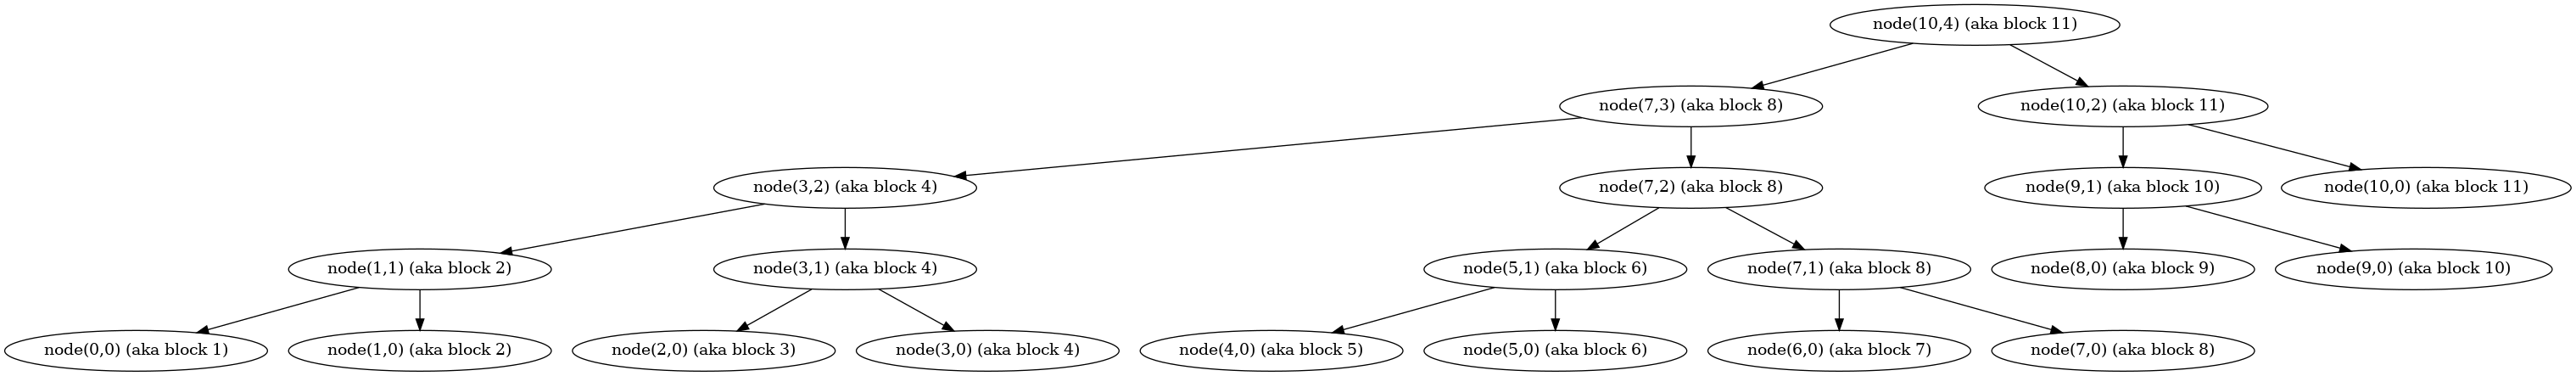

In [4]:
from anytree.exporter import DotExporter

from IPython.display import display, Image

DotExporter(t).to_picture("tree.png")
display(Image("tree.png"))


While the `merkle.tree` module contains a `traverse_hypothetical_tree` function which allows traversing through a hypothetical tree defined solely through the `NodeReference` of the root of the tree, we also are interested in a function that will traverse the actual Merkle tree. It follows a very similar algorithm as `traverse_hypothetical_tree`.

In [5]:
def traverse_tree_to_node(tree: TreeNode,
                          target_node_ref: NodeReference,
                          reducer: Callable[[TreeNode, Optional[TreeNode], Any], Any],
                          initial_state: Any = None) -> Any:
    """Traverse tree from root to the specified target node.

    For each node visited along the traversal, reducer is called with the third argument set the current value of the internal state.
    For all nodes other than the root node, reducer is called with the visited node as well as its sibling.
    For the root node, reducer is called with the visited node but the sibling argument is None (since the root has no sibling).

    Parameters:
        tree (TreeNode): Tree to traverse
        target_node_ref (NodeReference): Reference to target node
        reducer (function (TreeNode, Optional[TreeNode], Any) -> Any): 
            Function to call for each node visited along traversal.
            Function called with node visited, its sibling node, and the current value of the internal state.
            Function is expected to return the next value of the internal state.
        initial_state (Any): Initial value of the internal state before reducer is called for the first time.

    Returns:
        Value of the internal state after visiting all nodes in the traversal.

    Precondition: target_node_ref is a valid reference to a node within the tree
    """

    assert(tree_contains_node(tree.get_reference(), target_node_ref))

    num_bits: PositiveInt = log2(tree.max_ordinal).floor + 1
    bit_seq = [Bit(bit) for bit in "{:0{size}b}".format(
        target_node_ref.max_ordinal, size=num_bits)]

    bit_seq_iter = iter(bit_seq)

    cur_node: TreeNode = tree
    internal_state: Any = reducer(cur_node, None, initial_state)

    if cur_node.level <= target_node_ref.level:
        assert(cur_node.level == target_node_ref.level)
        assert(cur_node.max_ordinal == target_node_ref.max_ordinal)
        return internal_state

    maybe_bit: Optional[Bit] = next(bit_seq_iter, None)

    while maybe_bit != None:
        next_node: TreeNode = cur_node.children[maybe_bit]
        next_sibling_node: TreeNode = cur_node.children[int(
            not bool(maybe_bit))]

        for i in range(cur_node.level, next_node.level, -1):
            maybe_bit = next(bit_seq_iter, None)

        cur_node = next_node
        sibling_node = next_sibling_node

        internal_state = reducer(cur_node, sibling_node, internal_state)

        if cur_node.level <= target_node_ref.level:
            assert(cur_node.level == target_node_ref.level)
            assert(cur_node.max_ordinal == target_node_ref.max_ordinal)
            break

    return internal_state


We can now use the `traverse_tree_to_node` function to traverse from the root of our example tree `t` to its leaf node referenced by `NodeReference(5, 0)`.

In [6]:
def print_node(node: TreeNode, sibling: Optional[TreeNode], state: Any) -> None:
    if sibling == None:
        print("Visiting root node({node.max_ordinal},{node.level}) [\"{node.name}\"]".format(
            node=node))
    else:
        print("Visiting node({node.max_ordinal},{node.level}) [\"{node.name}\"] with sibling node({sibling.max_ordinal},{sibling.level}) [\"{sibling.name}\"]".format(
            node=node, sibling=sibling))


traverse_tree_to_node(t, NodeReference(5, 0), print_node)

Visiting root node(10,4) ["node(10,4) (aka block 11)"]
Visiting node(7,3) ["node(7,3) (aka block 8)"] with sibling node(10,2) ["node(10,2) (aka block 11)"]
Visiting node(7,2) ["node(7,2) (aka block 8)"] with sibling node(3,2) ["node(3,2) (aka block 4)"]
Visiting node(5,1) ["node(5,1) (aka block 6)"] with sibling node(7,1) ["node(7,1) (aka block 8)"]
Visiting node(5,0) ["node(5,0) (aka block 6)"] with sibling node(4,0) ["node(4,0) (aka block 5)"]


Importing the functions from the `merkle.tree` module also allows access to generating Merkle branch proof templates from hypothetical Merkle trees. That is the first step in the process of generating an actual Merkle branch proof including the cryptographic digests of the witness nodes.

The following is an example of the branch proof template generated for the 6th leaf node within a Merkle tree over 11 leaf nodes.

In [7]:
from pprint import pprint

from merkle.tree import *

my_proof_template = generate_branch_proof(tree_root_ref=NodeReference(10, 4), target_node_ref=NodeReference(5, 0))
pprint(my_proof_template.__dict__)


{'root': NodeReference(max_ordinal=10, level=4),
 'target': NodeReference(max_ordinal=5, level=0),
 'witnesses': [NodeReference(max_ordinal=4, level=0),
               NodeReference(max_ordinal=7, level=1),
               NodeReference(max_ordinal=3, level=2),
               NodeReference(max_ordinal=10, level=2)]}


The `verify_proof` function does not actually compute any cryptographic digests. It just verifies that the node references provided for the witnesses in the branch proof template are the appropriate ones to allow proving that the target node exists in the tree with the specified root.

In [8]:
verify_proof(my_proof_template)


True

Finally, the `lookup_nodes` function can take the branch proof template and generate a dictionary that lays out the exact strategy of where to find the appropriate cryptographic digests of the witness nodes needed to construct the actual Merkle branch proof.

In [9]:
my_proof_generation_strategy = lookup_nodes(my_proof_template)
pprint(my_proof_generation_strategy)


{NodeReference(max_ordinal=4, level=3): [NodeReference(max_ordinal=4, level=0)],
 NodeReference(max_ordinal=5, level=3): [NodeReference(max_ordinal=5, level=0)],
 NodeReference(max_ordinal=6, level=3): [NodeReference(max_ordinal=3, level=2)],
 NodeReference(max_ordinal=7, level=3): [NodeReference(max_ordinal=7, level=1)],
 NodeReference(max_ordinal=10, level=4): [NodeReference(max_ordinal=10, level=4),
                                          NodeReference(max_ordinal=10, level=2)]}
